Found 4000 validated image filenames belonging to 7 classes.
Found 1000 validated image filenames belonging to 7 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
Epoch 1/5


c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 516ms/step - accuracy: 0.5631 - loss: 1.3681 - val_accuracy: 0.6920 - val_loss: 0.8860
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 64s 497ms/step - accuracy: 0.7056 - loss: 0.8350 - val_accuracy: 0.7050 - val_loss: 0.8043
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 490ms/step - accuracy: 0.7180 - loss: 0.7781 - val_accuracy: 0.7380 - val_loss: 0.7606
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 486ms/step - accuracy: 0.7404 - loss: 0.6987 - val_accuracy: 0.7240 - val_loss: 0.7650
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 493ms/step - accuracy: 0.7564 - loss: 0.6806 - val_accuracy: 0.7370 - val_loss: 0.7334
Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.6922 - loss: 0.8963 - val_accuracy: 0.7400 - val_loss: 0.7795
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.7460 - loss: 0.7097 - val_accuracy: 0.7600 - val_loss: 0.7133
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.7859 - loss: 0.6042 - val_accuracy:

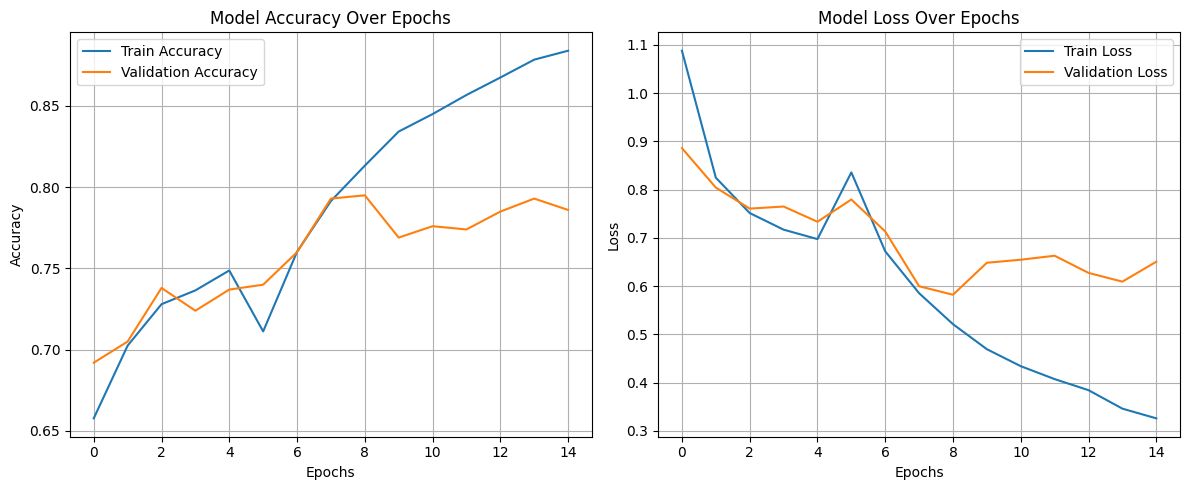

32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 498ms/step


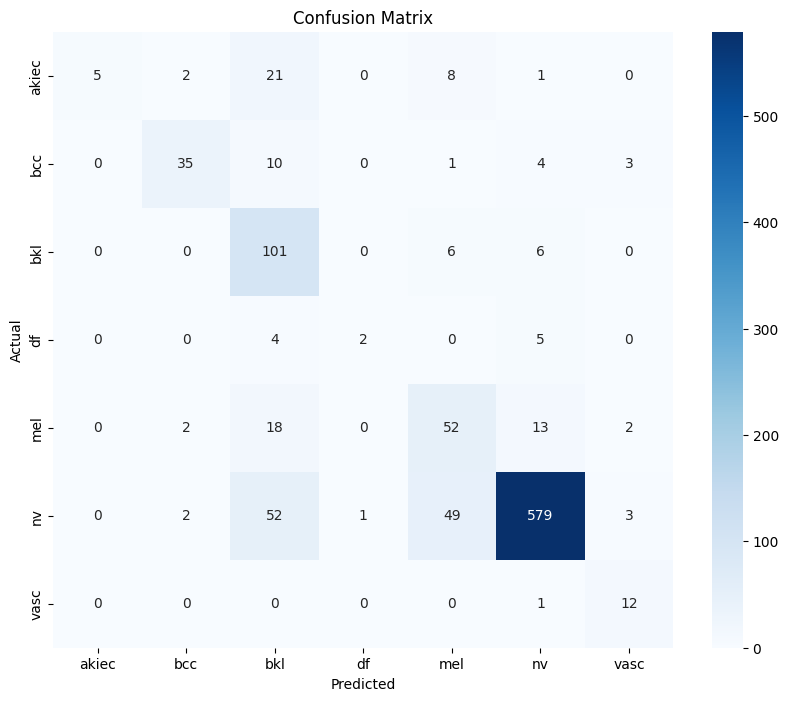

Classification Report:
               precision    recall  f1-score   support

       akiec       1.00      0.14      0.24        37
         bcc       0.85      0.66      0.74        53
         bkl       0.49      0.89      0.63       113
          df       0.67      0.18      0.29        11
         mel       0.45      0.60      0.51        87
          nv       0.95      0.84      0.89       686
        vasc       0.60      0.92      0.73        13

    accuracy                           0.79      1000
   macro avg       0.72      0.61      0.58      1000
weighted avg       0.84      0.79      0.79      1000

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


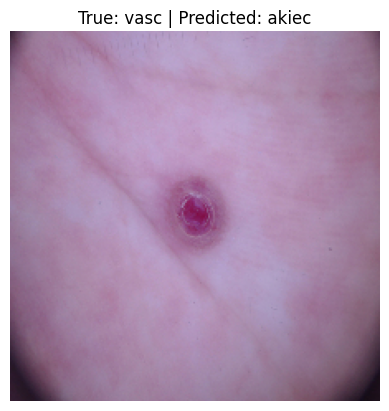

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


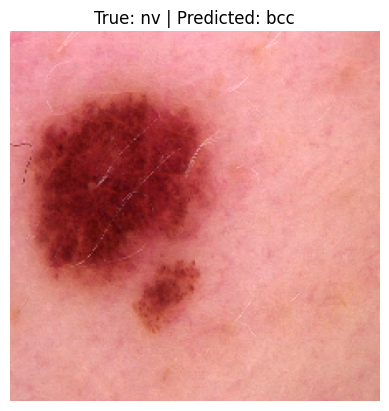

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


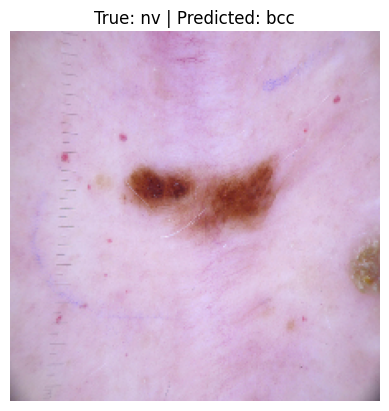

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


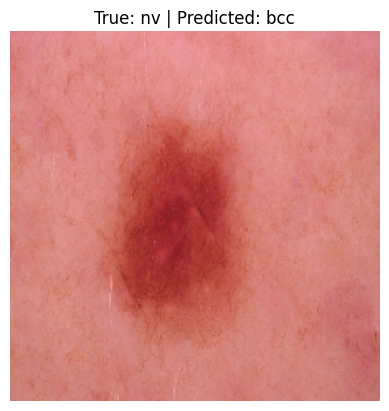

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


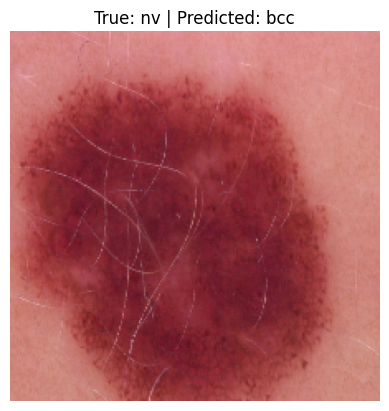

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Dataset Paths
IMAGE_DIR = "HAM10000_images_part_1"
CSV_PATH = "HAM10000_metadata.csv"

# Load metadata
df = pd.read_csv(CSV_PATH)
df['image_id'] = df['image_id'] + ".jpg"
df['path'] = df['image_id'].apply(lambda x: os.path.join(IMAGE_DIR, x))
df = df[df['path'].apply(os.path.exists)]
df['label'] = df['dx']
label_map = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label_idx'] = df['label'].map(label_map)

# Train/Validation Split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label_idx'], random_state=42)

# Image Preprocessing
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='path', y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
val_gen = val_datagen.flow_from_dataframe(
    val_df, x_col='path', y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load Pretrained DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(len(label_map), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Freeze base model initially
for layer in base_model.layers:
    layer.trainable = False

# Compile model (initial training)
model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
history1 = model.fit(train_gen, validation_data=val_gen, epochs=5)

# Fine-tune the full model
for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model.fit(train_gen, validation_data=val_gen, epochs=10)

# Save model
model.save("ham10000_densenet121_finetuned.h5")

# Combine histories
def combine_histories(h1, h2):
    combined = {}
    for k in h1.history:
        combined[k] = h1.history[k] + h2.history[k]
    return combined

history = combine_histories(history1, history2)

# Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation
val_preds = model.predict(val_gen)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_gen.classes

cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred, target_names=val_gen.class_indices.keys())

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_gen.class_indices.keys(),
            yticklabels=val_gen.class_indices.keys())
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

print("Classification Report:\n", cr)

# Sample Predictions Visualization
from tensorflow.keras.preprocessing import image
sample_df = val_df.sample(5, random_state=1)
for _, row in sample_df.iterrows():
    img_path = row['path']
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img) / 255.0
    pred = model.predict(np.expand_dims(img_array, axis=0))[0]
    pred_label = list(label_map.keys())[np.argmax(pred)]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {row['label']} | Predicted: {pred_label}")
    plt.show()
